In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle as pkl

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.gridspec as gridspec

# Visualize the Data

In [2]:
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Return,Open-Close,Open-Low,Open-High,Close-MA 20D,RSI 14D,Normalized Volume,Realized Volatility 30D,VIX,VIX Move,VIX Open-Close
0,1995-01-03,-0.000348,-0.000218,-0.004377,0.000131,0.007283,0.532690,-0.556965,0.100032,14.25,0.079545,0.011356
1,1995-01-04,0.003485,0.003441,-0.003420,0.003463,0.009975,0.563792,0.273094,0.099786,13.53,-0.050526,-0.024513
2,1995-01-05,-0.000803,-0.000847,-0.002127,0.001237,0.008364,0.554631,0.115542,0.097703,13.50,-0.002217,-0.014599
3,1995-01-06,0.000739,0.000652,-0.001977,0.004583,0.008066,0.561685,0.143239,0.081286,13.13,-0.027407,-0.039503
4,1995-01-09,0.000326,0.000347,-0.002019,0.002388,0.006700,0.564956,-0.229424,0.081226,13.33,0.015232,-0.014782


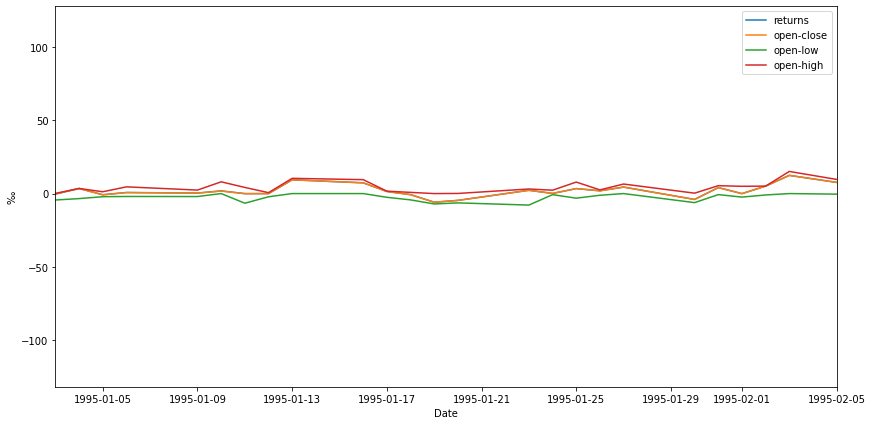

In [3]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Return']*1000, label = 'returns')
ax.plot(df['Date'], df['Open-Close']*1000, label = 'open-close')
ax.plot(df['Date'], df['Open-Low']*1000, label = 'open-low')
ax.plot(df['Date'], df['Open-High']*1000, label = 'open-high')

ax.set_xlabel('Date')
ax.set_ylabel('‰')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('1995-02-05'))
plt.legend()
plt.show()

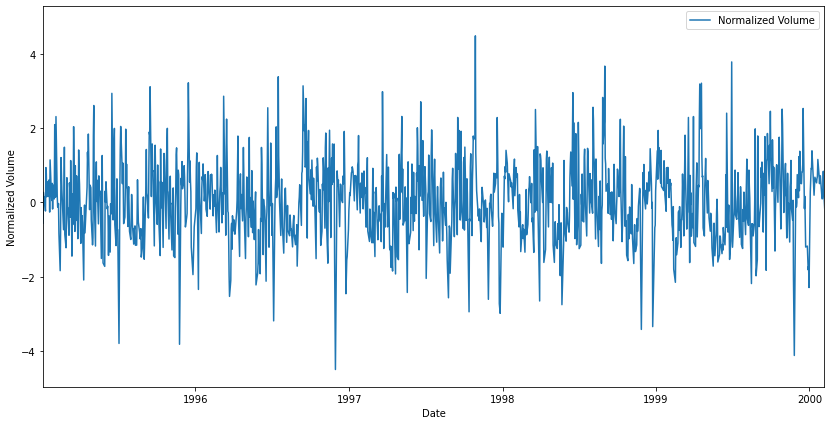

In [3]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Normalized Volume'], label = 'Normalized Volume')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Volume')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('2000-02-05'))
plt.legend()
plt.show()

# Single layer MLP GAN

In [4]:
def prep_data(data: np.array, window_len, scaler) -> np.array:
    
    """
    Args:
      -  data = np.array
      -  window_len = length of window
      -  scaler = sklearn.preprocessing

    Returns:
      - processed: preprocessed data as python list
    """
    # normalize data
    scaler = scaler.fit(data)
    scaled_data = scaler.transform(data)
    
    # group data into windows of length window_len
    windows = []
    for i in range(len(data) - window_len):
        windows.append(scaled_data[i:i+window_len])
        
    # reorder the data
    idx = np.random.permutation(len(windows))

    processed = []
    for i in range(len(windows)):
        processed.append(windows[idx[i]])
    
    return processed


Very simple GAN implementation for our baseline. Will use convolutions and TimeGAN as the next models

In [5]:
def train_gan(true_data, training_steps, generator, discriminator,lr = 0.001):

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr = lr)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

    # binary cross entropy loss
    loss = nn.BCELoss()
    true_data = torch.tensor(true_data).float()
    true_labels = torch.tensor(np.ones((len(true_data),1))).float()

    gen_data_loss = []
    true_data_loss = []
    for i in range(training_steps):
        
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # if minmaxscaling was used, the inputs should be bertween 0 and 1
        noise = torch.rand(true_data.shape[0], true_data.shape[1])
        
        # generator
        generated_data = generator(noise)
       
        generator_discriminator_out = discriminator(generated_data)
        
       # print(generator_discriminator_out.shape, true_labels.shape)
        
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()

        
        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)        
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros((len(true_data),1)))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        gen_data_loss.append(generator_discriminator_loss)
        true_data_loss.append(true_discriminator_loss)
        discriminator_loss.backward()
       
        discriminator_optimizer.step()
        if i%30==0:
           
            print("epoch: ", i, "discriminator loss: ",  discriminator_loss.item())
    return generator, discriminator, gen_data_loss, true_data_loss
        

In [6]:
# define minmax scaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
df = df.drop(['Close-MA 20D', 'RSI 14D','Realized Volatility 30D','VIX Move'], axis=1)
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)
data = np.array(data)
reshaped_data =  data.reshape(len(data),data.shape[1]*data.shape[2])

print(data.shape)

6769 (30, 7)
(6769, 30, 7)


In [7]:
class Generator2(torch.nn.Module):

    def __init__(self, input_length: int):
        super(Generator2, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_length,500),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(500,1200),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(1200,800),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(800,input_length)
                                    )
    def forward(self, x):
        return self.net(x)

In [8]:
class Discriminator2(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator2, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_length,500),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(500,400),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(400,400),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(400,1),
                                 nn.Sigmoid()
                                    )
    def forward(self, x):
        return self.net(x)

In [9]:
generator2 = Generator2(reshaped_data.shape[1])
discriminator2 = Discriminator2(reshaped_data.shape[1])
gen2, disc2, gen_loss2, disc_loss2 = train_gan(reshaped_data, 500, generator2, discriminator2,0.00005)

epoch:  0 discriminator loss:  0.7004406452178955
epoch:  30 discriminator loss:  0.6261663436889648
epoch:  60 discriminator loss:  0.5579832196235657
epoch:  90 discriminator loss:  0.26708152890205383
epoch:  120 discriminator loss:  0.3133220076560974
epoch:  150 discriminator loss:  0.5658557415008545
epoch:  180 discriminator loss:  0.3392506539821625
epoch:  210 discriminator loss:  0.40209293365478516
epoch:  240 discriminator loss:  0.34971678256988525
epoch:  270 discriminator loss:  0.3999505639076233
epoch:  300 discriminator loss:  0.4866771101951599
epoch:  330 discriminator loss:  0.7855550646781921
epoch:  360 discriminator loss:  0.5116236805915833
epoch:  390 discriminator loss:  0.4714999198913574
epoch:  420 discriminator loss:  0.5671594142913818
epoch:  450 discriminator loss:  0.5980818271636963
epoch:  480 discriminator loss:  0.6776151061058044


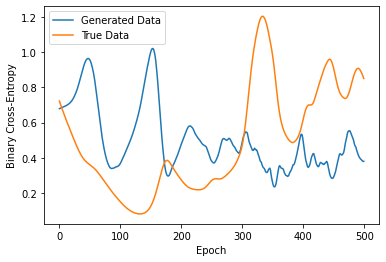

In [11]:
plt.plot(gen_loss2)
plt.plot(disc_loss2)
plt.legend(["Generated Data", "True Data"])
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy")
plt.show()

In [12]:
noise = torch.rand(reshaped_data.shape[0], reshaped_data.shape[1])
generated_data2 = gen2(noise)
generated_data2 = generated_data2.reshape(data.shape[0],data.shape[1],data.shape[2])
generated_data2 = generated_data2.detach().numpy()

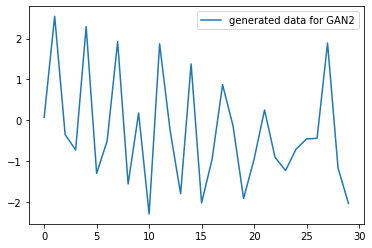

In [13]:
plt.plot(generated_data2[0,:,0],label='generated data for GAN2')
plt.legend()
plt.show()

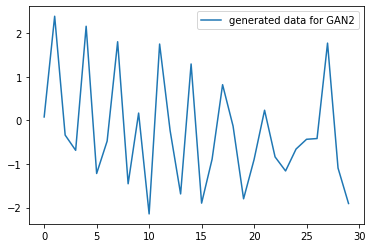

In [14]:
plt.plot(generated_data2[1000,:,0],label='generated data for GAN2')
plt.legend()
plt.show()

There is still the problem, that if you generate 1000 examples, they are always the same

# Analyzing Results

In [15]:
# define minmax scaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
df = df.drop(['Close-MA 20D', 'RSI 14D','Realized Volatility 30D','VIX Move'], axis=1)
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)
data = np.array(data)
reshaped_data =  data.reshape(len(data),data.shape[1]*data.shape[2])

print(data.shape)

6769 (30, 7)
(6769, 30, 7)


In [16]:
df.head()

,Return,Open-Close,Open-Low,Open-High,Normalized Volume,VIX,VIX Open-Close
Date,,,,,,,
1995-01-03,-0.000348,-0.000218,-0.004377,0.000131,-0.556965,14.25,0.011356
1995-01-04,0.003485,0.003441,-0.003420,0.003463,0.273094,13.53,-0.024513
1995-01-05,-0.000803,-0.000847,-0.002127,0.001237,0.115542,13.50,-0.014599
1995-01-06,0.000739,0.000652,-0.001977,0.004583,0.143239,13.13,-0.039503
1995-01-09,0.000326,0.000347,-0.002019,0.002388,-0.229424,13.33,-0.014782


## Visualizing synthetic data for GAN2

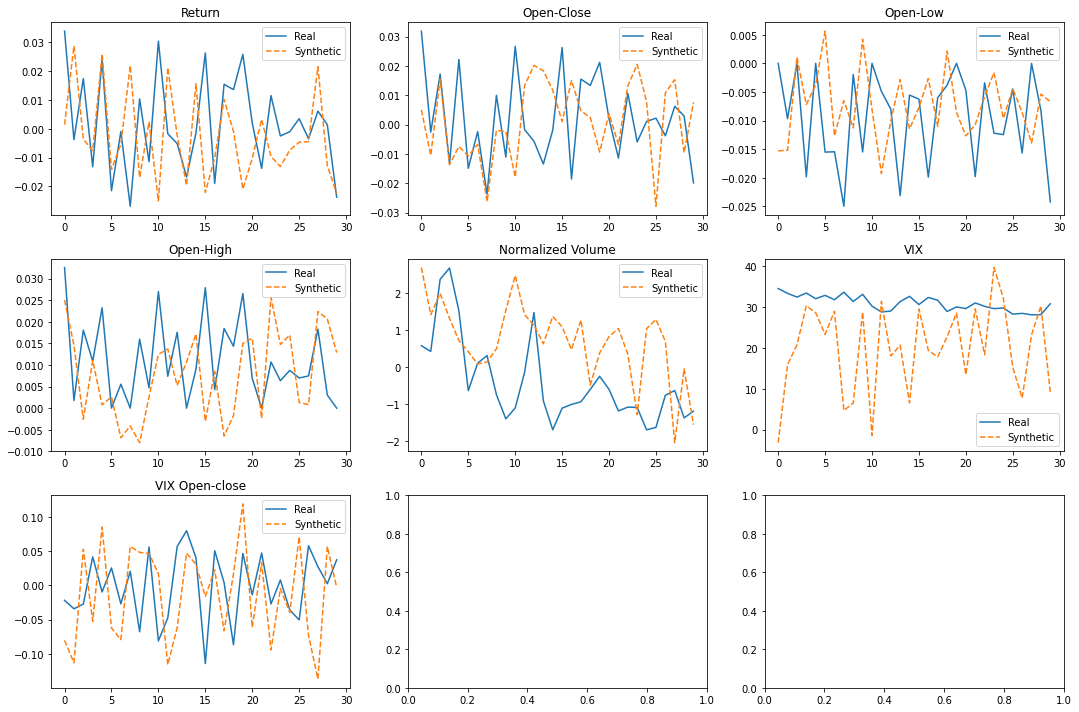

In [17]:
cols = [
    "Return","Open-Close",'Open-Low',"Open-High","Normalized Volume", "VIX", "VIX Open-close"
]

# Plotting some generated samples. Both Synthetic and Original data are still standardized with values between [0, 1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,30))
obs = np.random.randint(len(generated_data2.shape))
unscaled_data = scaler.inverse_transform(data)
unscaled_generated2 = scaler.inverse_transform(generated_data2)
for j, col in enumerate(cols):
    frame = pd.DataFrame({'Real': unscaled_data[obs][:, j],
                   'Synthetic': unscaled_generated2[obs][:, j]})
    frame.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()


## PCA for GAN2

In [18]:
seq_len = 30
sample_size = 100
# get random indexes
idx = np.random.permutation(len(data))[:sample_size]
real_sample = data[idx]
synthetic_sample = generated_data2[idx]

# reshape
real_data_reduced = real_sample.reshape(-1, seq_len)
synth_data_reduced = synthetic_sample.reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)

pca.fit(real_data_reduced)

pca_real = pd.DataFrame(pca.transform(real_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data_reduced, synth_data_reduced), axis=0)

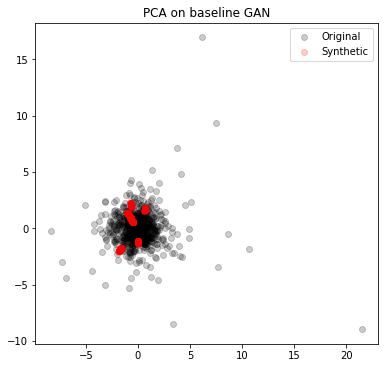

In [19]:

fig = plt.figure(constrained_layout=True, figsize=(10, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA on baseline GAN')

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')

plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')


ax.legend()

Better, but still what's happening is that if i generate 6000 samples, they are all exactly the same, which is why the pca is a single point. At least this time the points are neared to the true distribution

## TNSE for GAN2

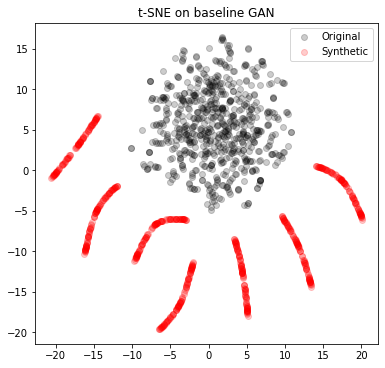

In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=n_components, n_iter=300)

tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

fig = plt.figure(constrained_layout=True, figsize=(10, 5))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax2 = fig.add_subplot(spec[0,0])
ax2.set_title('t-SNE on baseline GAN')

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:700, 0].values, tsne_results.iloc[:700, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[700:, 0], tsne_results.iloc[700:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

In [38]:
with open("data.pkl", "wb") as f:
    pkl.dump(data, f)
with open("gen_data.pkl", "wb") as f:
    pkl.dump(generated_data2, f)

print(generated_data2[0])
print(generated_data2[1])

[[ 0.07183909  0.4523669  -1.1304619   2.785197    2.6694765  -2.971201
  -1.3691338 ]
 [ 2.5460107  -1.0354223  -1.1157517   1.227315    1.3978946  -0.5149519
  -1.967417  ]
 [-0.3537572   1.4667673   0.97965604 -1.317148    1.97322     0.09855133
   0.9935675 ]
 [-0.7271549  -1.3700321  -0.06851213  0.69834703  1.3013018   1.314833
  -0.88845944]
 [ 2.2922251  -0.7569763   0.36870357 -0.8240108   0.70567834  1.0959334
   1.5760027 ]
 [-1.3023983  -1.082161    1.585588   -0.5500657   0.39294785  0.44208592
  -1.0574777 ]
 [-0.507124   -0.6898403  -0.7812293  -1.9370395   0.07470207  1.151613
  -1.368743  ]
 [ 1.9252385  -2.5587468  -0.00413217 -1.5512125   0.14075896 -1.9553192
   1.0747885 ]
 [-1.5598283  -0.22829583 -0.6092167  -2.1172676   0.4870608  -1.7111919
   0.9240281 ]
 [ 0.17534442 -0.2652426   1.4077744  -0.5366936   1.5142522   1.1469407
   0.8803806 ]
 [-2.2939498  -1.7667274  -0.18752491  0.90738714  2.4524279  -2.7460072
   0.3644379 ]
 [ 1.8707893   1.2553684  -1.6514